## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Fixed Random Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## Data Load

In [3]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

## Data preprocessing

In [4]:
df = jeju_power_market_day_ahead

In [5]:
df['datetimes'] = pd.to_datetime(df['ts'], unit='s')

# 3. 월, 일, 시각 열 추가
df['hour'] = df['datetimes'].dt.hour

df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [6]:
df

,ts,datetimes,hour,하루전가격(원/kWh)
0,1709218800,2024-02-29 15:00:00,15,107.39
1,1709222400,2024-02-29 16:00:00,16,107.39
2,1709226000,2024-02-29 17:00:00,17,95.30
3,1709229600,2024-02-29 18:00:00,18,87.89
4,1709233200,2024-02-29 19:00:00,19,0.00
...,...,...,...,...
5660,1729594800,2024-10-22 11:00:00,11,156.68
5661,1729598400,2024-10-22 12:00:00,12,152.54
5662,1729602000,2024-10-22 13:00:00,13,106.92
5663,1729605600,2024-10-22 14:00:00,14,150.97


In [7]:
df = df.drop(['ts', 'datetimes'], axis=1)

In [8]:
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [9]:
df

,hour,하루전가격(원/kWh)
0,15,107.39
1,16,107.39
2,17,95.30
3,18,87.89
4,19,0.00
...,...,...
5660,11,156.68
5661,12,152.54
5662,13,106.92
5663,14,150.97


In [10]:
train_df = df[:int(len(df) * 0.8)]
vali_df = df[int(len(df) * 0.8):]

In [11]:
train_df

,hour,하루전가격(원/kWh)
0,15,107.39
1,16,107.39
2,17,95.30
3,18,87.89
4,19,0.00
...,...,...
4527,6,150.69
4528,7,152.93
4529,8,152.93
4530,9,160.70


In [43]:
input_size = 2  # feature의 개수
hidden_size = 16
num_layers = 2
output_size = 1
num_epochs = 100
window_size = 64  # 예측에 사용될 시간 윈도우 크기
batch_size = 32
learning_rate = 0.001

In [75]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df.values
        self.window_size = window_size

    def __len__(self):
        # 마지막에 남은 샘플이 window_size + 24보다 작으면 제외
        return len(self.df) - (self.window_size + 24) + 1

    def __getitem__(self, idx):
        x = torch.tensor(self.df[idx:idx + self.window_size, :], dtype=torch.float)
        y = torch.tensor(self.df[idx + self.window_size: idx + self.window_size + 24, -1], dtype=torch.float)
        return x, y

def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader


train_loader = create_data_loader(train_df, window_size, batch_size)

In [109]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=24):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 24개의 출력값을 예측할 수 있도록 Linear 레이어 수정
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 초기 hidden state 및 cell state 생성
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM에 입력을 전달하고 hidden states를 가져옵니다
        out, _ = self.lstm(x, (h0, c0))
        
        # LSTM의 마지막 타임스텝의 출력만을 사용하여 예측
        out = self.fc(out[:, -1, :])

        return out

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size=24).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: cuda


In [114]:
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

/home/jinjinjara1022/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 24])) that is different to the input size (torch.Size([32, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/jinjinjara1022/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([29, 1, 24])) that is different to the input size (torch.Size([29, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Step [139/139], Loss: 18708.0273
Epoch [2/100], Step [139/139], Loss: 17340.2051
Epoch [3/100], Step [139/139], Loss: 16149.0586
Epoch [4/100], Step [139/139], Loss: 15053.1797
Epoch [5/100], Step [139/139], Loss: 14030.8457
Epoch [6/100], Step [139/139], Loss: 13071.7148
Epoch [7/100], Step [139/139], Loss: 12169.5967
Epoch [8/100], Step [139/139], Loss: 11320.1279
Epoch [9/100], Step [139/139], Loss: 10519.8711
Epoch [10/100], Step [139/139], Loss: 9766.1367
Epoch [11/100], Step [139/139], Loss: 9056.4883
Epoch [12/100], Step [139/139], Loss: 8388.7881
Epoch [13/100], Step [139/139], Loss: 7761.1001
Epoch [14/100], Step [139/139], Loss: 7171.6685
Epoch [15/100], Step [139/139], Loss: 6618.8257
Epoch [16/100], Step [139/139], Loss: 6101.0396
Epoch [17/100], Step [139/139], Loss: 5616.8354
Epoch [18/100], Step [139/139], Loss: 5164.8096
Epoch [19/100], Step [139/139], Loss: 4743.6143
Epoch [20/100], Step [139/139], Loss: 4351.9438
Epoch [21/100], Step [139/139], Loss: 39

In [115]:
vali_df

,hour,하루전가격(원/kWh)
4532,11,161.03
4533,12,161.03
4534,13,161.03
4535,14,161.03
4536,15,140.15
...,...,...
5660,11,156.68
5661,12,152.54
5662,13,106.92
5663,14,150.97


In [116]:
test_loader = create_data_loader(vali_df, window_size, 1)

In [122]:
for idx, (i) in enumerate(test_loader):
    X = i[0].to(device)
    pred = model(X)
    
    print(pred)
    if idx % 24 == 0:
        print(i[1])
    break

tensor([[137.3743, 137.3662, 137.3140, 137.3891, 137.4444, 137.4504, 137.3528,
         137.4045, 137.2832, 137.2427, 137.1811, 137.2618, 137.3139, 137.2802,
         137.1784, 137.2173, 137.1106, 137.0659, 136.9838, 137.0069, 137.0491,
         136.9077, 136.8401, 136.7248]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[141.3500, 143.9100, 141.3400, 143.1900, 160.3700, 160.3700, 163.5100,
         163.5100, 163.7800, 163.7800, 162.0500, 161.3800, 160.7600, 137.2200,
         106.8800, 106.8800, 106.8800, 106.8800, 106.8800, 139.9700, 142.4600,
         146.3500, 151.1900, 159.5300]])


In [91]:
real = []
pred = []

for X, y in test_loader:
    inputs = X.to(device)
    outputs = model(inputs)
    
    tmp = outputs.detach()

    print(tmp)
    break
    real.append(list(y[0]))
    pred.append(list(tmp[0]))

tensor([[137.5546]], device='cuda:0')


In [90]:
pred

[[tensor(137.5546, device='cuda:0')],
 [tensor(137.5550, device='cuda:0')],
 [tensor(137.5544, device='cuda:0')],
 [tensor(137.5498, device='cuda:0')],
 [tensor(137.5451, device='cuda:0')],
 [tensor(137.5495, device='cuda:0')],
 [tensor(137.5449, device='cuda:0')],
 [tensor(137.5432, device='cuda:0')],
 [tensor(137.5392, device='cuda:0')],
 [tensor(137.5340, device='cuda:0')],
 [tensor(137.5272, device='cuda:0')],
 [tensor(137.5185, device='cuda:0')],
 [tensor(137.5061, device='cuda:0')],
 [tensor(137.4911, device='cuda:0')],
 [tensor(137.1811, device='cuda:0')],
 [tensor(136.5771, device='cuda:0')],
 [tensor(136.4743, device='cuda:0')],
 [tensor(136.4367, device='cuda:0')],
 [tensor(136.4121, device='cuda:0')],
 [tensor(136.3930, device='cuda:0')],
 [tensor(136.5305, device='cuda:0')],
 [tensor(136.5358, device='cuda:0')],
 [tensor(137.4976, device='cuda:0')],
 [tensor(137.5536, device='cuda:0')],
 [tensor(137.5592, device='cuda:0')],
 [tensor(137.5595, device='cuda:0')],
 [tensor(137

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

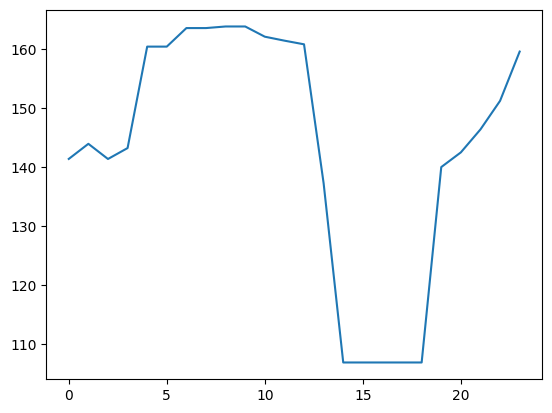

In [89]:
plt.plot(real[0])
plt.plot(pred[0])